In [38]:
import re
from tqdm.notebook import tqdm

from IPython.display import display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers

from covid_flu import config, utils, time_series, plotting

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df_flu = utils.load_flu_data()
display(df_flu.head())
display(df_flu.tail())

,time,wili,state
0,2010-40,2.13477,Alabama
1,2010-41,2.05999,Alabama
2,2010-42,1.94224,Alabama
3,2010-43,2.27650,Alabama
4,2010-44,2.83371,Alabama


,time,wili,state
456,2019-27,0.280899,Wyoming
457,2019-28,0.166021,Wyoming
458,2019-29,0.000100,Wyoming
459,2019-30,0.000100,Wyoming
460,2019-31,0.000100,Wyoming


## Simple RNN model: predicting `d` days from a fixed input length

In [110]:
df_flu.values[np.argwhere(df_flu['state'].values == 'New York')]

array([[['2010-40', 0.26299, 'New York']],

       [['2010-41', 0.369729, 'New York']],

       [['2010-42', 0.362121, 'New York']],

       ...,

       [['2019-29', 0.4943, 'New York']],

       [['2019-30', 0.511351, 'New York']],

       [['2019-31', 0.562652, 'New York']]], dtype=object)

In [281]:
# Preparing data
HISTORY_SIZE = 25
TARGET_SIZE = 1

def prepare_time_series_data(ts, groups=None, history_size=HISTORY_SIZE, target_size=TARGET_SIZE):  
    X_all, y_all = [], []
    if groups is None:
        X_all, y_all = _prepare_ts_single(ts, history_size, target_size)
    else:
        for group in np.unique(groups):
            subset = ts[np.argwhere(groups == group)]
            hist, trg = _prepare_ts_single(subset, history_size, target_size)
            X_all.extend(hist)
            y_all.extend(trg)
            
    X_all = np.stack(X_all, axis=0)
    y_all = np.stack(y_all, axis=0)

    return X_all, y_all


def _prepare_ts_single(ts, history_size, target_size):
    X_all, y_all = [], []
    ts_len = len(subset)
    for i in range(ts_len - history_size - target_size):
        hist, trg = time_series.prepare_univariate_time_series(subset, history_size, target_size, offset=i)
        X_all.append(hist)
        y_all.append(trg)
    return X_all, y_all


def prepare_and_split_ts(ts, groups=None, history_size=HISTORY_SIZE, target_size=TARGET_SIZE, test_size=0.2):
    X_all, y_all = prepare_time_series_data(ts, groups=groups, history_size=history_size, target_size=target_size)
    len_test = int(np.ceil(len(X_all) * test_size))
    return X_all[:-len_test], X_all[-len_test:], y_all[:-len_test], y_all[-len_test:]
#     return train_test_split(X_all, y_all, test_size=test_size)


def _make_datasets(X_train, X_test, y_train, y_test, batch_size=256, buffer_size=1000):
    ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    ds_train = ds_train.cache().shuffle(buffer_size).batch(batch_size).repeat()

    ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    ds_test = ds_test.cache().shuffle(buffer_size).batch(batch_size).repeat()
    
    return ds_train, ds_test


def prepare_data(ts, groups=None, history_size=HISTORY_SIZE, target_size=TARGET_SIZE, test_size=0.2):
    splits = prepare_and_split_ts(ts, 
                                  groups=groups, 
                                  history_size=history_size, 
                                  target_size=target_size, 
                                  test_size=0.2)
    return _make_datasets(*splits)

In [188]:
ds_train, ds_test = prepare_data(df_flu['wili'].values, df_flu['state'].values,
                                 history_size=25, target_size=1, test_size=0.2)

### Constructing the RNN

In [189]:
def make_simple_lstm(history_length=25, target_length=1, hidden_size=8, pre_output_dense_size=None):
    simple_lstm = tf.keras.models.Sequential()
    simple_lstm.add(layers.LSTM(hidden_size, input_shape=(history_length,1)))
    if pre_output_dense_size:
        simple_lstm.add(layers.Dense(pre_output_dense_size))
    simple_lstm.add(layers.Dense(target_length))
    
    simple_lstm.compile(optimizer='adam', loss='mse')
    return simple_lstm

In [192]:
simple_lstm = make_simple_lstm()

In [199]:
simple_lstm.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 8)                 320       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [193]:
EPOCHS = 20
STEPS_PER_EPOCH = 50
history = simple_lstm.fit(ds_train, epochs=EPOCHS, validation_data=ds_test,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=50)

Train for 50 steps, validate for 50 steps
Epoch 1/20
50/50 [==============================] - 3s 59ms/step - loss: 3.9168 - val_loss: 3.1677
Epoch 2/20
50/50 [==============================] - 1s 20ms/step - loss: 2.5126 - val_loss: 2.2231
Epoch 3/20
50/50 [==============================] - 1s 20ms/step - loss: 2.0010 - val_loss: 1.7680
Epoch 4/20
50/50 [==============================] - 1s 20ms/step - loss: 1.6625 - val_loss: 1.5398
Epoch 5/20
50/50 [==============================] - 1s 20ms/step - loss: 1.3735 - val_loss: 1.4931
Epoch 6/20
50/50 [==============================] - 1s 20ms/step - loss: 1.2049 - val_loss: 1.2071
Epoch 7/20
50/50 [==============================] - 1s 20ms/step - loss: 0.9988 - val_loss: 0.8804
Epoch 8/20
50/50 [==============================] - 1s 20ms/step - loss: 0.8238 - val_loss: 0.8653
Epoch 9/20
50/50 [==============================] - 1s 19ms/step - loss: 0.7110 - val_loss: 0.6599
Epoch 10/20
50/50 [==============================] - 1s 19ms/step -

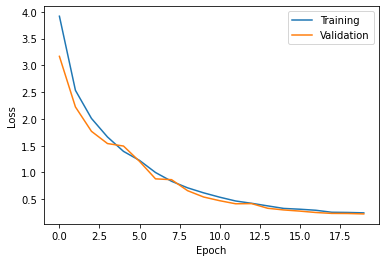

In [194]:
plotting.plot_history(history)

In [264]:
def plot_model_pred(model, X, y=None, idx=None, ax=None):
    if y is None and isinstance(X, tf.data.Dataset):
        X_eval, y_eval = next(X.unbatch().batch(1).take(1).as_numpy_iterator())
    else:
        if not idx:
            idx = np.random.choice(len(X))

        X_eval = X_test[idx].reshape(1, -1, 1)
        y_eval = y_test[idx].reshape(-1, 1)
    y_pred = model.predict(X_eval).reshape(-1, 1)

    plotting.plot_time_series_prediction(X_eval, y_eval, y_pred, ax=ax)
#     plt.show()

In [228]:
plot_model_pred(simple_lstm, ds_test)

ValueError: Error when checking input: expected lstm_11_input to have shape (25, 1) but got array with shape (50, 1)

## Trying to predict a longer time horizon

In [282]:
history_size = 50
target_size = 5
ds_train, ds_test = prepare_data(df_flu['wili'].values, df_flu['state'].values,
                                 history_size=history_size, target_size=target_size)
lstm2 = make_simple_lstm(history_length=history_size, target_length=target_size)
lstm2.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 8)                 320       
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 45        
Total params: 365
Trainable params: 365
Non-trainable params: 0
_________________________________________________________________


In [218]:
EPOCHS = 25
STEPS_PER_EPOCH = 50
history2 = lstm2.fit(ds_train, epochs=EPOCHS, validation_data=ds_test,
                     steps_per_epoch=STEPS_PER_EPOCH,
                     validation_steps=50)

Train for 50 steps, validate for 50 steps
Epoch 1/25
50/50 [==============================] - 2s 36ms/step - loss: 2.4960 - val_loss: 2.3213
Epoch 2/25
50/50 [==============================] - 2s 36ms/step - loss: 2.2105 - val_loss: 2.0801
Epoch 3/25
50/50 [==============================] - 2s 36ms/step - loss: 2.0227 - val_loss: 1.8564
Epoch 4/25
50/50 [==============================] - 2s 35ms/step - loss: 1.7507 - val_loss: 1.6422
Epoch 5/25
50/50 [==============================] - 2s 33ms/step - loss: 1.5356 - val_loss: 1.4219
Epoch 6/25
50/50 [==============================] - 2s 34ms/step - loss: 1.3718 - val_loss: 1.2614
Epoch 7/25
50/50 [==============================] - 2s 37ms/step - loss: 1.1917 - val_loss: 1.1213
Epoch 8/25
50/50 [==============================] - 2s 40ms/step - loss: 1.0889 - val_loss: 1.0132
Epoch 9/25
50/50 [==============================] - 2s 38ms/step - loss: 0.9775 - val_loss: 0.9288
Epoch 10/25
50/50 [==============================] - 2s 36ms/step -

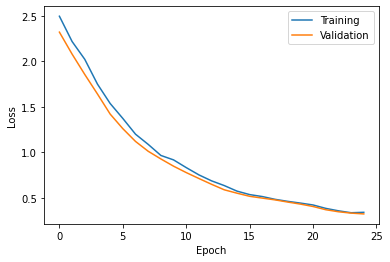

In [220]:
plotting.plot_history(history2)

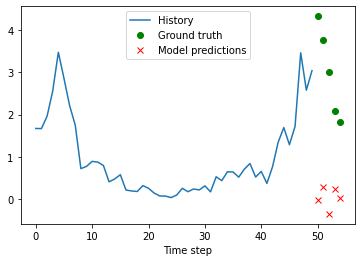

In [258]:
plot_model_pred(lstm2, ds_test)

## Adding a pre-output dense layer and more hidden nodes

In [283]:
history_size = 50
target_size = 5
hidden_size = 16
pre_output_dense_size = 32
lstm3 = make_simple_lstm(history_length=history_size, target_length=target_size,
                         hidden_size=hidden_size, pre_output_dense_size=pre_output_dense_size)
lstm3.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 16)                1152      
_________________________________________________________________
dense_16 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 165       
Total params: 1,861
Trainable params: 1,861
Non-trainable params: 0
_________________________________________________________________


In [284]:
EPOCHS = 25
STEPS_PER_EPOCH = 50
history3 = lstm3.fit(ds_train, epochs=EPOCHS, validation_data=ds_test,
                     steps_per_epoch=STEPS_PER_EPOCH,
                     validation_steps=50)

Train for 50 steps, validate for 50 steps
Epoch 1/25
50/50 [==============================] - 6s 115ms/step - loss: 2.4084 - val_loss: 1.6354
Epoch 2/25
50/50 [==============================] - 2s 39ms/step - loss: 1.2625 - val_loss: 0.9941
Epoch 3/25
50/50 [==============================] - 2s 38ms/step - loss: 0.8098 - val_loss: 0.6553
Epoch 4/25
50/50 [==============================] - 2s 39ms/step - loss: 0.5474 - val_loss: 0.4403
Epoch 5/25
50/50 [==============================] - 2s 39ms/step - loss: 0.4032 - val_loss: 0.3463
Epoch 6/25
50/50 [==============================] - 3s 51ms/step - loss: 0.2882 - val_loss: 0.2677
Epoch 7/25
50/50 [==============================] - 2s 40ms/step - loss: 0.2504 - val_loss: 0.2549
Epoch 8/25
50/50 [==============================] - 2s 39ms/step - loss: 0.2612 - val_loss: 0.2338
Epoch 9/25
50/50 [==============================] - 2s 40ms/step - loss: 0.2256 - val_loss: 0.2265
Epoch 10/25
50/50 [==============================] - 2s 40ms/step 

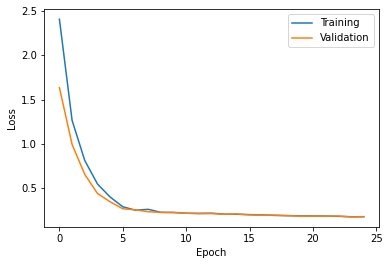

In [285]:
plotting.plot_history(history3)

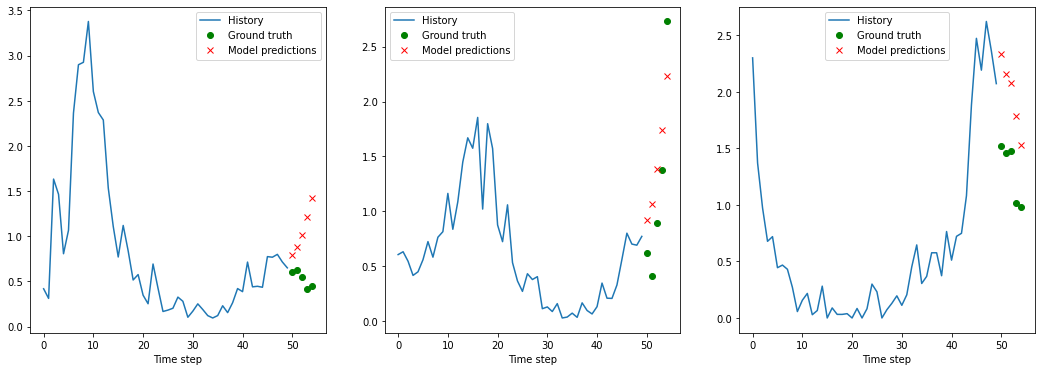

In [286]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax in axs:
    plot_model_pred(lstm3, ds_test, ax=ax)